In [1]:
import numpy as np
import xarray as xr
from matplotlib import pyplot as plt
%matplotlib inline

import xrft
from glob import glob

In [2]:
ds = xr.Dataset(coords={'time': ('time', np.arange(3000)*3600.)})
ds = ds.assign(u=np.cos(2.*np.pi*2/86400.*ds.time)+np.random.randn(ds.time.size))
ds = ds.assign(v=np.sin(2.*np.pi*2/86400.*ds.time)+np.random.randn(ds.time.size))
print(ds)

<xarray.Dataset>
Dimensions:  (time: 3000)
Coordinates:
  * time     (time) float64 0.0 3.6e+03 7.2e+03 1.08e+04 1.44e+04 1.8e+04 ...
Data variables:
    u        (time) float64 0.2427 2.126 0.6476 1.496 -0.2346 -0.2318 ...
    v        (time) float64 0.1175 -1.234 0.4354 1.249 1.139 0.112 0.1806 ...


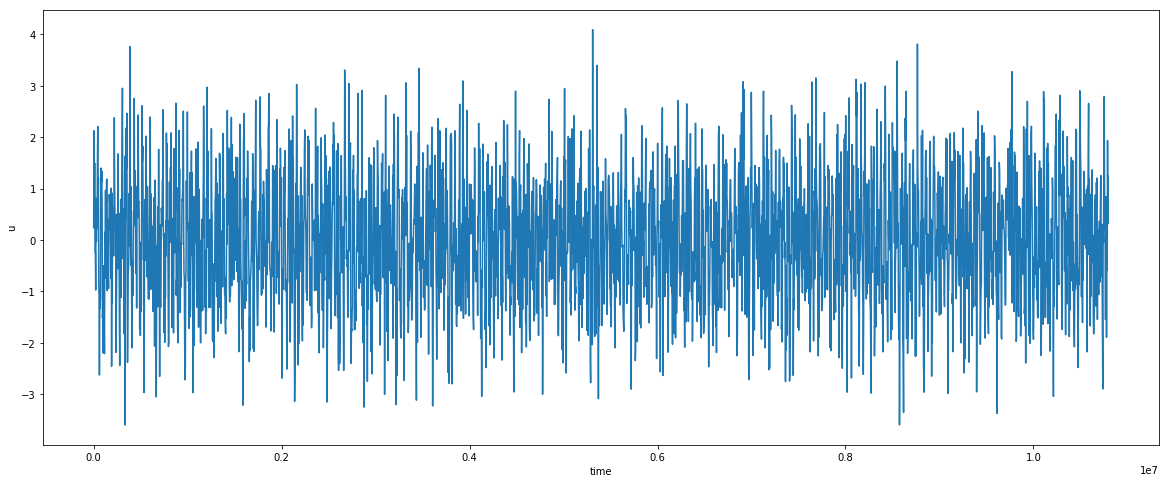

In [3]:
fig, ax = plt.subplots(figsize=(20,8))
ds['u'].plot()

# Normal FFT

In [4]:
u_normal = ds['u']

u_fft_normal = xrft.dft(u_normal.fillna(0.), shift=False, detrend='linear', window=False)

E_u_normal = (u_fft_normal*u_fft_normal.conj()).where(u_fft_normal!=0., drop=False)

print(E_u_normal)
E_u_normal = np.real(E_u_normal).rename('u_power_spectrum')

<xarray.DataArray (freq_time: 3000)>
array([3.231174e-27+0.j, 1.278562e+03+0.j, 2.624498e+02+0.j, ...,
       1.994579e+03+0.j, 2.624498e+02+0.j, 1.278562e+03+0.j])
Coordinates:
  * freq_time          (freq_time) float64 0.0 9.259e-08 1.852e-07 2.778e-07 ...
    freq_time_spacing  float64 9.259e-08


###### ______

# FFT with a Hanning window (50% overlap windows)

In [5]:
E_dir = '/home1/scratch/xyu/mit_spec/E_u_1d/'

nfft = 300
noverlap = nfft/2
window = np.hanning(nfft)

T = np.arange(0, len(ds['u'].time)-int(nfft/2), int(nfft/2))

print(T)

[   0  150  300  450  600  750  900 1050 1200 1350 1500 1650 1800 1950
 2100 2250 2400 2550 2700]


In [6]:
E_dir = '/home1/scratch/xyu/mit_spec/E_u_1d/'

nfft = 300
noverlap = nfft/2
window = np.hanning(nfft)

T = np.arange(0, len(ds['u'].time)-int(nfft/2), int(nfft/2))

for t in T:
    
    u = ds['u'].isel(time=slice(t,t+nfft))   
    u_fft = xrft.dft(window*u.fillna(0.), shift=False, detrend='linear', window=False)
    E_u = (u_fft*u_fft.conj()).where(u_fft!=0., drop=False)
    #E_u = E_u.astype('f8').rename('E_u')
    E_u = np.real(E_u).rename('E_u')
    #file_E = E_dir+'E_u_t%04d_tt%03d.nc'%t,t 
    file_E = E_dir+'E_u_t{1:.0f}_t{1:.0f}.nc'.format(t,t)     
    E_u.to_netcdf(file_E, mode='w')  

/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.6/site-packages/dask/utils.py:1010: UserWarning: Deprecated, see dask.base.get_scheduler instead
  warnings.warn("Deprecated, see dask.base.get_scheduler instead")
/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.6/site-packages/distributed/utils.py:128: RuntimeWarning: Couldn't detect a suitable IP address for reaching '8.8.8.8', defaulting to '127.0.0.1': [Errno 101] Network is unreachable
  % (host, default, e), RuntimeWarning)
/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.6/site-packages/dask/utils.py:1010: UserWarning: Deprecated, see dask.base.get_scheduler instead
  warnings.warn("Deprecated, see dask.base.get_scheduler instead")
/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.6/site-packages/dask/utils.py:1010: UserWarning: Deprecated, see dask.base.get_scheduler instead
  warnings.warn("Deprecated, see dask.base.get_scheduler instead")
/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.6

In [7]:
filenames = sorted(glob(E_dir+'E_u_t*.nc'))
%time ds = xr.open_mfdataset(filenames, concat_dim='blocks', compat='equals')
print(ds)

CPU times: user 72 ms, sys: 4 ms, total: 76 ms
Wall time: 82 ms
<xarray.Dataset>
Dimensions:            (blocks: 19, freq_time: 300)
Coordinates:
  * freq_time          (freq_time) float64 0.0 9.259e-07 1.852e-06 2.778e-06 ...
    freq_time_spacing  float64 9.259e-07
Dimensions without coordinates: blocks
Data variables:
    E_u                (blocks, freq_time) float64 dask.array<shape=(19, 300), chunksize=(1, 300)>


In [8]:
E = (ds.E_u).mean(dim='blocks')
print(E)

<xarray.DataArray 'E_u' (freq_time: 300)>
dask.array<shape=(300,), dtype=float64, chunksize=(300,)>
Coordinates:
  * freq_time          (freq_time) float64 0.0 9.259e-07 1.852e-06 2.778e-06 ...
    freq_time_spacing  float64 9.259e-07


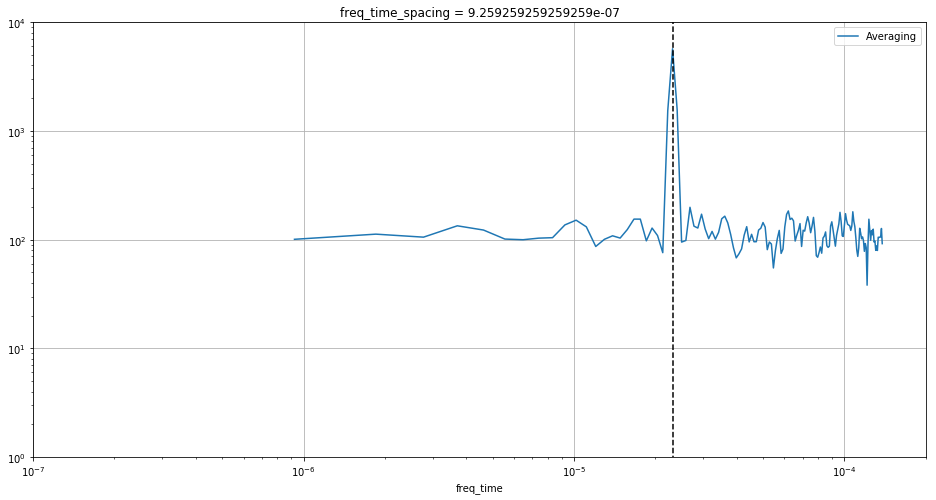

In [9]:
fig, ax = plt.subplots(figsize=(16,8))

labels = ['Normal', 'Averaging']

E.where(E.freq_time>0).plot(ax=ax, label=labels[1])
ax.legend(); ax.grid()
ax.set_xscale('log'); ax.set_yscale('log')
ax.set_ylabel(''); 

ax.set_xlim([1e-7,2*1e-4])
ax.set_ylim([1e0,1e4])

ax.plot([1/12/3600,1/12/3600],[1e-2,1e6],'k--',) 



# Comparison

(1.0, 10000000.0)

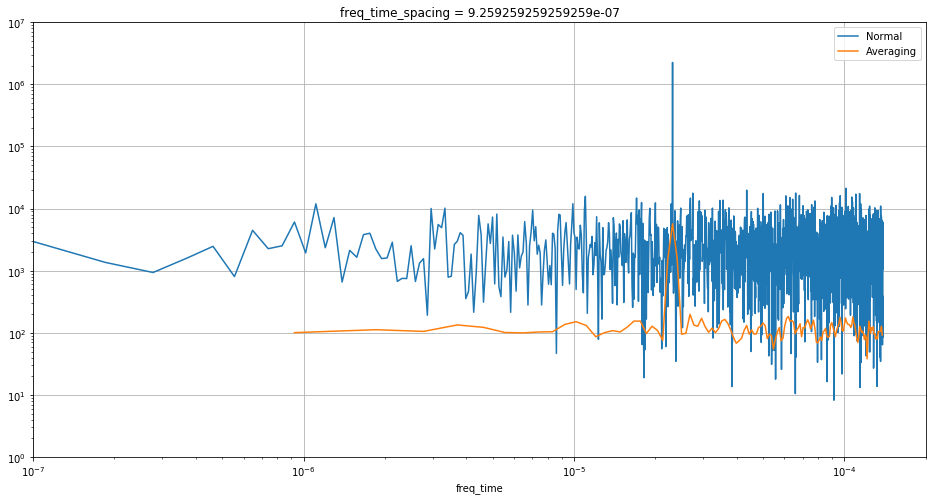

In [10]:
fig, ax = plt.subplots(figsize=(16,8))

labels = ['Normal', 'Averaging']


E_u_normal.where(E_u_normal.freq_time>0).plot(ax=ax, label=labels[0])
E.where(E.freq_time>0).plot(ax=ax, label=labels[1])
ax.legend(); ax.grid()
ax.set_xscale('log'); ax.set_yscale('log')
ax.set_ylabel(''); 

ax.set_xlim([1e-7,2*1e-4])
ax.set_ylim([1e0,1e7])

# power spectral density normalization

In [5]:
print(ds)

<xarray.Dataset>
Dimensions:  (time: 3000)
Coordinates:
  * time     (time) float64 0.0 3.6e+03 7.2e+03 1.08e+04 1.44e+04 1.8e+04 ...
Data variables:
    u        (time) float64 1.682 0.6261 0.4006 -0.06607 -0.3126 -2.434 ...
    v        (time) float64 -1.159 2.003 0.9791 0.6752 1.427 0.4314 1.285 ...


In [6]:
energy_time = ds['u']*ds['u']
print(energy_time)

<xarray.DataArray 'u' (time: 3000)>
array([2.82775 , 0.39198 , 0.160504, ..., 0.522031, 0.543319, 0.049659])
Coordinates:
  * time     (time) float64 0.0 3.6e+03 7.2e+03 1.08e+04 1.44e+04 1.8e+04 ...


In [7]:
energy_time_mean = energy_time.mean(dim='time')

print(energy_time_mean)

<xarray.DataArray 'u' ()>
array(1.546562)


In [8]:
u_normal = ds['u']

u_fft_normal = xrft.dft(u_normal.fillna(0.), shift=False, detrend='linear', window=False)

#E_u_normal = (u_fft_normal*u_fft_normal.conj()).where(u_fft_normal!=0., drop=False)/u_fft_normal.freq_time_spacing/ds.time.size**2

E_u_normal = (u_fft_normal*u_fft_normal.conj()).where(u_fft_normal!=0., drop=False)/ds.time.size*3600

print(E_u_normal)
E_u_normal = np.real(E_u_normal).rename('u_power_spectrum')

<xarray.DataArray (freq_time: 3000)>
array([3.877409e-27+0.j, 1.534274e+03+0.j, 3.149397e+02+0.j, ...,
       2.393495e+03+0.j, 3.149397e+02+0.j, 1.534274e+03+0.j])
Coordinates:
  * freq_time          (freq_time) float64 0.0 9.259e-08 1.852e-07 2.778e-07 ...
    freq_time_spacing  float64 9.259e-08


In [12]:
df = 1/3600/3000
energy_freq_mean = E_u_normal.sum(dim='freq_time')*df
print(energy_freq_mean)

<xarray.DataArray 'u_power_spectrum' ()>
array(1.545808)
Coordinates:
    freq_time_spacing  float64 9.259e-08


In [10]:
df = 1/3600/3000
print(df)

9.259259259259259e-08


In [13]:
ds.time.size

3000

In [14]:
u = ds['u'].values

In [15]:
fu = np.fft.fftn(u)

In [16]:
np.mean(u**2)

1.5465618038800284

In [17]:
np.sum(abs(fu)**2)/u.size**2/df*df

1.5465618038800284

In [19]:
np.sum(abs(fu)**2)/u.size**2/df*df

1.5465618038800284